## AlexNet (2012) with tf.keras

## Overview
AlexNet architecture, based on their paper (<a>https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks</a>). Tf keras used in this implemention.

With 60M parameters, AlexNet has 8 layers — 5 convolutional and 3 fully-connected. AlexNet just stacked a few more layers onto LeNet-5. At the point of publication, the authors pointed out that their architecture was “one of the largest convolutional neural networks to date on the subsets of ImageNet.”

⭐️What’s novel?
1. They were the first to implement Rectified Linear Units (ReLUs) as activation functions.

In [4]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist as mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split

### Download Data Set & Normalize


In [ ]:
!wget --no-check-certificate \
   https://github.com/ck196/tensorflow-alexnet/blob/master/17flowers.tar.gz?raw=true \
    -O ../datasets/17flowers.tar.gz

In [ ]:
import tarfile

local_tar = '../datasets/17flowers.tar.gz'
tar = tarfile.open(local_tar, "r:gz")
tar.extractall('../datasets/')
tar.close()

In [5]:
def load_image(path):
    img =image.load_img(path,target_size=(227,227))
    img = image.img_to_array(img)
    #img = np.expand_dims(img, axis=3)
    return img

In [6]:
PATH = '../datasets/17flowers/jpg'
labels = [label for label in os.listdir(PATH) if os.path.isdir(os.path.join(PATH,label))]
print(f'LABELS: {labels}')
x_train = []
y_train = []
for label in labels:
    path = os.path.join(PATH,label)
    files = os.listdir(path)
    for file in files:
        x_train.append(load_image(os.path.join(path,file)))
        y_train.append(label)
        
x_train = np.array(x_train).astype('float32')
y_train = np.array(y_train).astype('int32')

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

LABELS: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '2', '3', '4', '5', '6', '7', '8', '9']
(1088, 227, 227, 3)
(1088,)
(272, 227, 227, 3)
(272,)


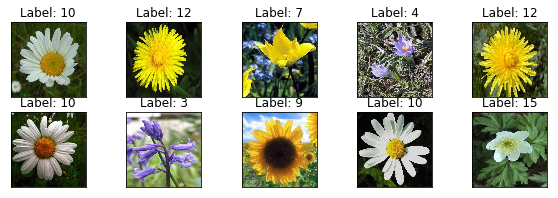

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
for i in range(10):
  index=i*100
  img = np.reshape(x_train[index],(227,227,3))
  img = img.astype('uint8')
  plt.subplot(5,5,i+1).set_title(f'Label: {y_train[index]}')
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])

In [8]:
# To prevent overfitting , ImageDataGenerator used to re-generate images with new scale.
batch_size = 64
train_image_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# for test data generator just uses rescale
validation_image_generator = ImageDataGenerator(
    rescale = 1./255
)

train_gen = train_image_generator.flow(x_train, y_train, batch_size=batch_size)
validation_gen = validation_image_generator.flow(x_test, y_test, batch_size=batch_size)

### AlexNet Architecture
<img src="https://engmrk.com/wp-content/uploads/2018/10/AlexNet_Summary_Table.jpg" alt="Architecture" style="width: 500px; float:center"/>

In [15]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
model = tf.keras.models.Sequential([
    Conv2D(96, (11,11), input_shape=(227,227,3), strides=(4,4), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3),  strides=(1,1), padding='same', activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(384, (3,3),  strides=(1,1), padding='same',  activation='relu'),
    Conv2D(384, (3,3),  strides=(1,1), padding='same',  activation='relu'),
    Conv2D(256, (3,3),  strides=(1,1), padding='same', activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dropout(0.4),
    Dense(17, activation='softmax')
])

model.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 27, 27, 256)       221440    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 13, 13, 384)       1327488   
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 256)       884992    
__________

In [16]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=len(x_train) / batch_size,
                              epochs=50,
                              validation_data=validation_gen,
                              validation_steps=len(x_test) / batch_size)

model.evaluate(x_test, y_test)

Epoch 1/50
17/17 [==============================] - 7s 390ms/step - loss: 3.4163 - acc: 0.0542 - val_loss: 2.8364 - val_acc: 0.0515
Epoch 2/50
17/17 [==============================] - 8s 487ms/step - loss: 2.8135 - acc: 0.0662 - val_loss: 2.7709 - val_acc: 0.1066
Epoch 3/50
17/17 [==============================] - 8s 498ms/step - loss: 2.5349 - acc: 0.1186 - val_loss: 2.3896 - val_acc: 0.1544
Epoch 4/50
17/17 [==============================] - 9s 504ms/step - loss: 2.3733 - acc: 0.1489 - val_loss: 2.3975 - val_acc: 0.1544
Epoch 5/50
17/17 [==============================] - 9s 503ms/step - loss: 2.3185 - acc: 0.1526 - val_loss: 2.3236 - val_acc: 0.1801
Epoch 6/50
17/17 [==============================] - 8s 494ms/step - loss: 2.2572 - acc: 0.2013 - val_loss: 2.1354 - val_acc: 0.2868
Epoch 7/50
17/17 [==============================] - 8s 498ms/step - loss: 2.1433 - acc: 0.2316 - val_loss: 2.1214 - val_acc: 0.2206
Epoch 8/50
17/17 [==============================] - 8s 498ms/step - loss: 2.

17/17 [==============================] - 9s 511ms/step - loss: 0.7481 - acc: 0.7362 - val_loss: 1.0709 - val_acc: 0.6507
Epoch 40/50
17/17 [==============================] - 9s 502ms/step - loss: 0.7819 - acc: 0.7233 - val_loss: 0.9782 - val_acc: 0.7096
Epoch 41/50
17/17 [==============================] - 9s 508ms/step - loss: 0.6863 - acc: 0.7528 - val_loss: 0.9885 - val_acc: 0.6949
Epoch 42/50
17/17 [==============================] - 9s 500ms/step - loss: 0.8175 - acc: 0.7215 - val_loss: 0.9312 - val_acc: 0.6838
Epoch 43/50
17/17 [==============================] - 9s 500ms/step - loss: 0.8228 - acc: 0.7114 - val_loss: 1.0553 - val_acc: 0.6949
Epoch 44/50
17/17 [==============================] - 9s 501ms/step - loss: 0.7637 - acc: 0.7408 - val_loss: 1.0585 - val_acc: 0.6728
Epoch 45/50
17/17 [==============================] - 9s 521ms/step - loss: 0.6717 - acc: 0.7647 - val_loss: 0.9556 - val_acc: 0.7243
Epoch 46/50
17/17 [==============================] - 9s 500ms/step - loss: 0.6533

[8.413497419918285, 0.4742647]

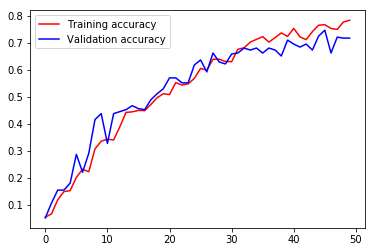

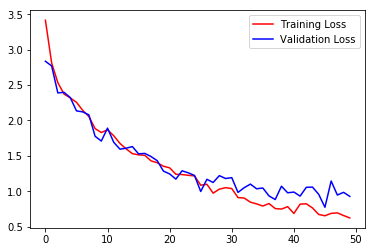

In [17]:
## Visualize the Training Process
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
#plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
#plt.title('Training and validation loss')
plt.legend()

plt.show()